In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bosonic import Qubit, GKPQubit, BosonicRegister, BosonicCircuit, execute, QubitRotationGate, extend_op_to_circ

from jax import jit, grad
import jax.numpy as jnp
import qutip as qt
import numpy as np

# Speed Comparisons

### Setup

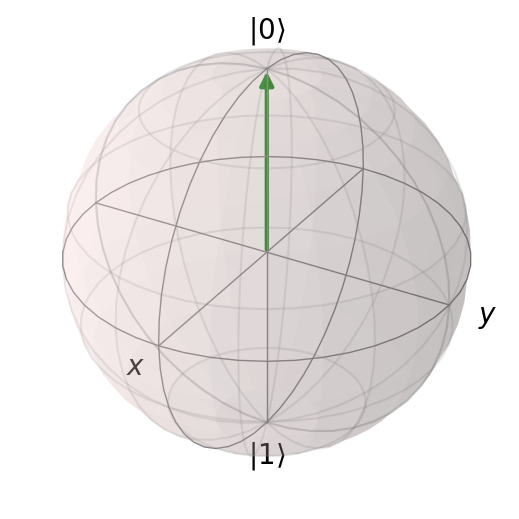

In [3]:
qubit = Qubit()
breg = BosonicRegister([qubit])
bcirc = BosonicCircuit(breg)
H0 = qt.sigmaz()
c_ops = [np.sqrt(1)*qt.sigmam()]

# set up circuit
bcirc.reset()

# bcirc.x(0)
bcirc.add(QubitRotationGate, 0, params={"omega": 1, "theta": np.pi/2}, ts = np.linspace(0, np.pi / 2, 101))

# plots initial state
bcirc.plot(0)

### Unitary Comparisons

<ipython-input-4-b1288bdd8052>:3: DeprecationWarning: Please use the 'unitary_jax' backend instead.
  results = execute(bcirc, "unitary")


626 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
411 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


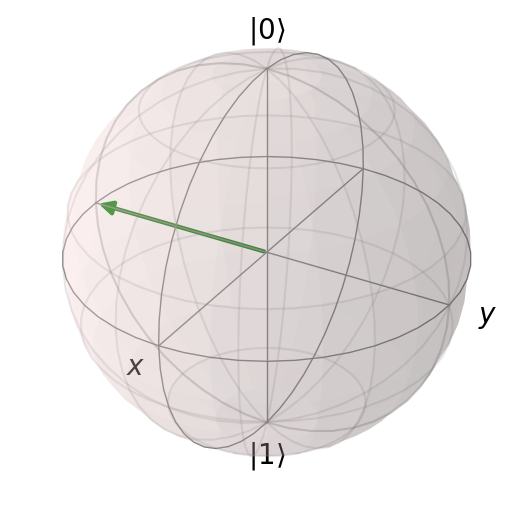

In [4]:
# no loss and no H0
def exp_U():
    results = execute(bcirc, "unitary")
    return results

%timeit -n1 -r1 exp_U()
%timeit exp_U()

res_U = exp_U()
res_U.plot(bcirc, 0)

13.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.99 µs ± 143 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


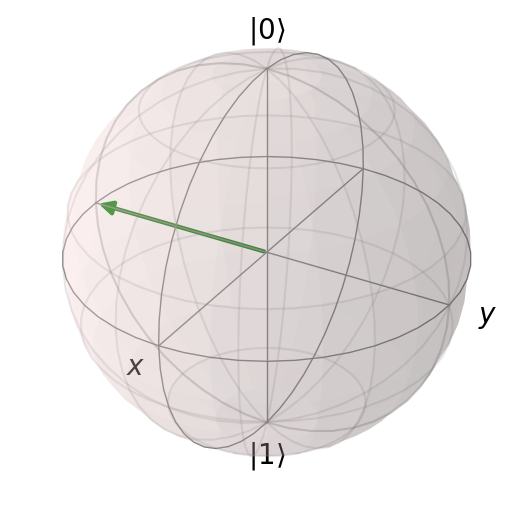

In [5]:
# no loss and no H0
@jit
def exp_U_jax():
    results = execute(bcirc, "unitary_jax")
    return results

%timeit -n1 -r1 exp_U_jax()
%timeit exp_U_jax()

res_U_jax = exp_U_jax()
res_U_jax.plot(bcirc, 0)

### Hamiltonian Comparisons

381 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.72 ms ± 682 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


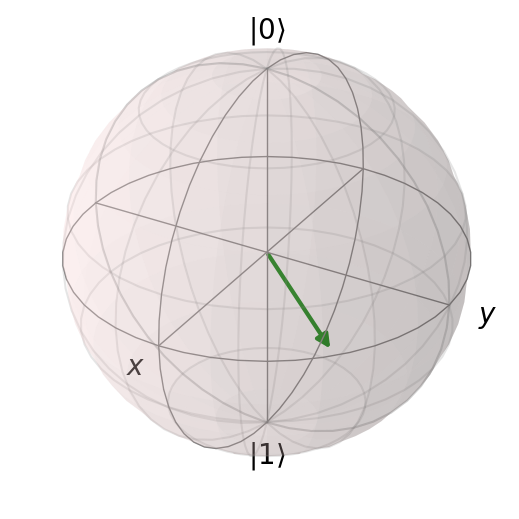

In [6]:
def exp():
    results = execute(bcirc, "hamiltonian", H0=H0, c_ops=c_ops)
    return results

%timeit -n1 -r1 exp()
%timeit exp()

res = exp()
res.plot(bcirc, 0)

1.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
258 µs ± 7.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


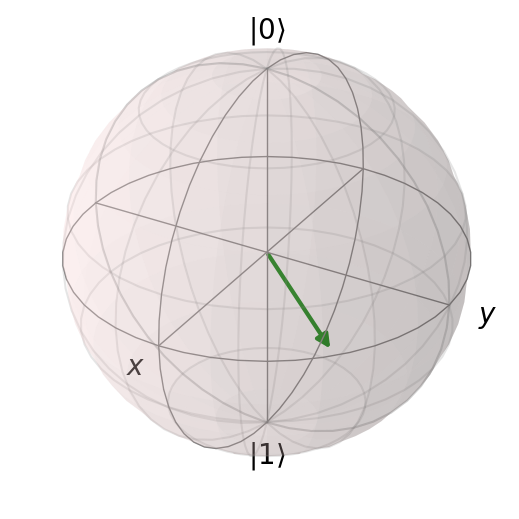

In [7]:
H0_jax = jnp.array(H0)
c_ops_jax = jnp.array(c_ops)

@jit
def exp_jax():
    results = execute(bcirc, "hamiltonian_jax", H0=H0_jax, c_ops=c_ops_jax)
    return results

%timeit -n1 -r1 exp_jax()
%timeit exp_jax()

res_jax = exp_jax()

res_jax.plot(bcirc, 0)

In [8]:
# Check Final States
rho = jnp.array(res[-1]["states"][-1])
rho_jax = res_jax[-1]["states"][-1]

print("Original:\n", rho,"\n")
print("JAX:\n", rho_jax,"\n")

print("Max percent diff (%): \n", np.max(np.abs(rho - rho_jax)/np.abs(rho)*100))

Original:
 [[ 0.23937504+0.j         -0.04682855-0.15981621j]
 [-0.04682855+0.15981621j  0.76062496+0.j        ]] 

JAX:
 [[ 0.239375  +0.j         -0.04682842-0.15981653j]
 [-0.04682842+0.15981653j  0.760625  +0.j        ]] 

Max percent diff (%): 
 0.00021190418624998222


# Gradient Descent

In [9]:
qubit_loss = Qubit(params={"N":200})
breg_loss = BosonicRegister([qubit_loss])
bcirc_loss = BosonicCircuit(breg_loss)

H0 = qt.sigmaz()
H0_jax = jnp.array(H0)
c_ops = [np.sqrt(1)*qt.sigmam()]
c_ops_jax = jnp.array(c_ops)

@jit
def exp_jax_loss(omega):
    # set up circuit
    bcirc_loss.reset()
    bcirc_loss.add(QubitRotationGate, 0, params={"omega": omega, "theta": jnp.pi/2}, ts = jnp.linspace(0, np.pi / 2, 101))
    results_loss = execute(bcirc_loss, "hamiltonian_jax", H0=H0_jax, c_ops=c_ops_jax)
    return jnp.real(results_loss[-1]["states"][-1][0][0])

exp_grad = jit(grad(exp_jax_loss))

%timeit -n1 -r1 exp_grad(1.0)
%timeit exp_grad(1.0)

exp_grad(1.0)

3.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.46 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


DeviceArray(0.0733901, dtype=float64, weak_type=True)